# Conditional VAE for LHC Olympics 2020 dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import pandas as pd
from tqdm import tqdm

import tensorflow as tf

from tensorflow import keras

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Input, Dense, Add, Activation, Concatenate
from tensorflow.keras.callbacks import History, ModelCheckpoint, Callback
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, Concatenate, LeakyReLU, Reshape, Conv2DTranspose, Flatten, Conv2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Attention
from tensorflow.keras.callbacks import ReduceLROnPlateau

#from sklearn.mixture import GaussianMixtur
from sklearn.model_selection import train_test_split

from utils import *

In [2]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

physical_devices = tf.config.experimental.list_physical_devices()
print("All available physical devices:", physical_devices)

# Select a GPU device for training
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    device = gpu_devices[0]
    tf.config.experimental.set_memory_growth(device, True)
    tf.config.experimental.set_visible_devices(device, 'GPU')
    print("Selected GPU device:", device)
else:
    print("No GPU devices found.")
    

All available physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Selected GPU device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Load training and test data

In [3]:
# outerdata_train = np.load("./data/preprocessed_data_6var/outerdata_train_6var.npy")
# outerdata_test = np.load("./data/preprocessed_data_6var/outerdata_test_6var.npy")
outerdata_train = np.load("/global/u2/a/agarabag/pscratch/GAEA/data/preprocessed_data_6var_more_training_data/outerdata_train_6var.npy")
outerdata_test = np.load("/global/u2/a/agarabag/pscratch/GAEA/data/preprocessed_data_6var_more_training_data/outerdata_test_6var.npy")

print(outerdata_test.shape)

# Num of feature stored in the data files
nFeat = 6
# Num of feature we want to use for training
input_dim = 6

outerdata_train = outerdata_train[outerdata_train[:,nFeat+1]==0]
outerdata_test = outerdata_test[outerdata_test[:,nFeat+1]==0]

# reserve 100,000 events for training as validation set
outerdata_train, outerdata_val = train_test_split(outerdata_train, test_size=100000, random_state=42)
print('shape of outerdata_val: ', outerdata_val.shape)

data_train = outerdata_train[:,1:nFeat+1]
print('shape of data_train: ', data_train.shape)
data_test = outerdata_test[:,1:nFeat+1]
print('shape of data_test: ', data_test.shape)

data = np.concatenate((data_train, data_test), axis=0)
og_data = data.copy()
print('shape of data: ', data.shape)

cond_data_train = outerdata_train[:,0]
print('shape of cond_train', cond_data_train.shape)
cond_data_test = outerdata_test[:,0]
print('shape of cond_test', cond_data_test.shape)

cond_data = np.concatenate((cond_data_train, cond_data_test), axis=0)
og_cond_data = cond_data.copy()
print('shape of cond_data: ', cond_data.shape)


(28876, 8)
shape of outerdata_val:  (100000, 8)
shape of data_train:  (749779, 6)
shape of data_test:  (28869, 6)
shape of data:  (778648, 6)
shape of cond_train (749779,)
shape of cond_test (28869,)
shape of cond_data:  (778648,)


In [4]:
innerdata_train = np.load("/global/u2/a/agarabag/pscratch/GAEA/data/preprocessed_data_6var_more_training_data/innerdata_train_6var.npy")
innerdata_test = np.load("/global/u2/a/agarabag/pscratch/GAEA/data/preprocessed_data_6var_more_training_data/innerdata_test_6var.npy")
print(innerdata_train.shape)
print(innerdata_test.shape)

innerdata_train = innerdata_train[innerdata_train[:,nFeat+1]==0]
innerdata_test  = innerdata_test[innerdata_test[:,nFeat+1]==0]
print(innerdata_train.shape)

data_sr_train = innerdata_train[:,1:nFeat+1]
data_sr_test = innerdata_test[:,1:nFeat+1]
x_SR = np.concatenate((data_sr_train, data_sr_test), axis=0)
og_x_SR = x_SR.copy()
print(x_SR.shape)

y_innerdata_train = innerdata_train[:,0]
y_innerdata_test = innerdata_test[:,0]
y_SR = np.concatenate((y_innerdata_train, y_innerdata_test), axis=0)
og_y_SR = y_SR.copy()
print(y_SR.shape)

(60000, 8)
(60000, 8)
(59605, 8)
(99605, 6)
(99605,)


## Plot training features

- Total 6 training features
- 1 conditional feature
- Training Features are scaled to such that they are in range [0,1]

In [5]:
feature_names = {
                0: "$m_{2}$",
                1: "$\Delta m = m_{1} - m_{2}$ ",
                2: "$\\tau_{21}^{J1}$",
                3: "$\\tau_{21}^{J2}$",
                4: "$\\tau_{32}^{J1}$",
                5: "$\\tau_{32}^{J2}$"
    
}

In [6]:
feature_labels = {
                0: "Min. Jet Mass",
                1: "Jet Mass Difference",
                2: "$\\tau_{21}$ Lead Jet",
                3: "$\\tau_{21}$ Sublead Jet",
                4: "$\\tau_{32}$ Lead Jet",
                5: "$\\tau_{32}$ Sublead Jet"
    
}

In [7]:
def plot_variables(data, density = False):
    
    plt.figure(figsize=(12,12))
    if density == False:
        plt.ylabel("Events")
    else:
        plt.ylabel("Normalized events")
    
    
    for i in range(input_dim):
        plt.subplot((input_dim+1)//2, 2, i+1)
        plt.xlabel(feature_names[i])
        plt.hist(data[:, i], bins=30, color = "darkblue",  histtype = "step", label = feature_labels[i], density = density)
        plt.legend(loc = 'upper right', prop={'size': 18})
        plt.yscale('log')


/tmp/ipykernel_145083/780718071.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot((input_dim+1)//2, 2, i+1)


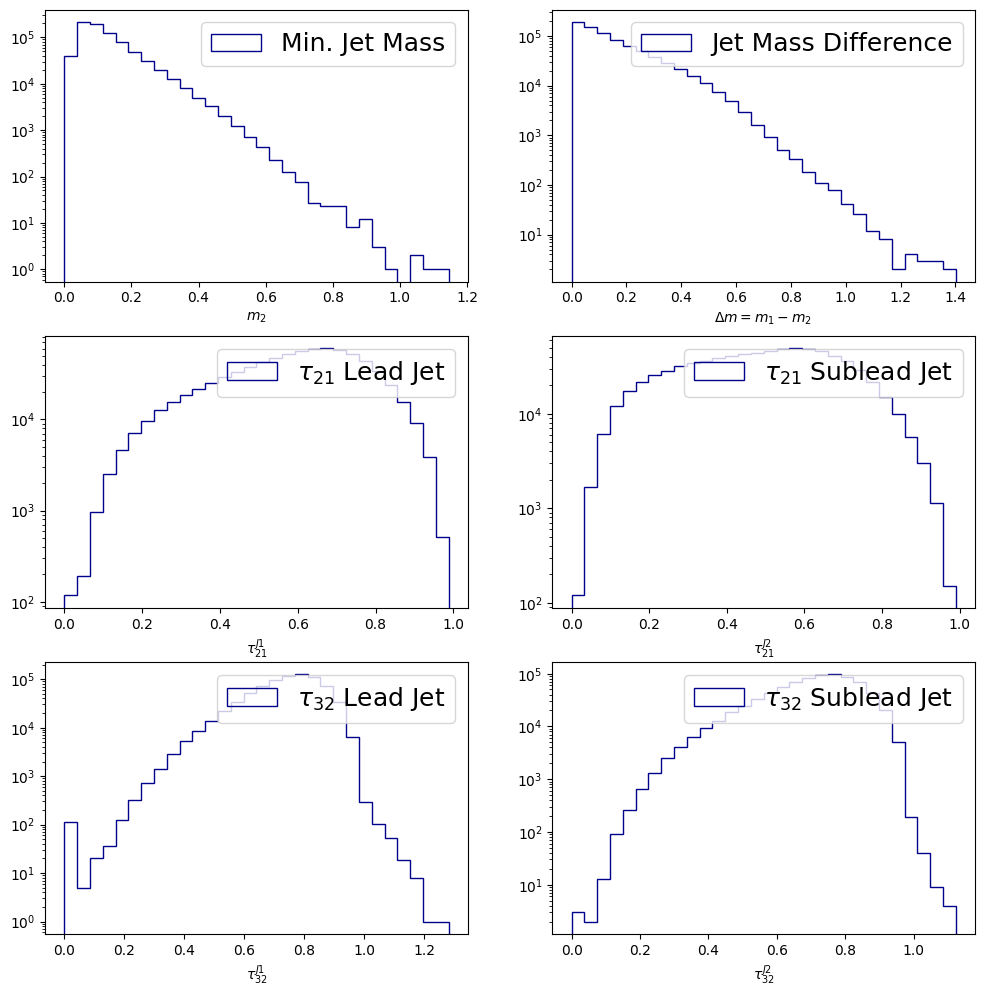

In [8]:
plot_variables(data)


### Feature scaling
<!-- Dividing each feature by the `abs(maximum)` value -->

In [9]:
# lower cond_data 
# data = data[cond_data <= 3.3]
# cond_data = cond_data[cond_data <= 3.3]

#upper cond_data
# data = data[cond_data >= 3.7]
# cond_data = cond_data[cond_data >= 3.7]

#normalization
data, data_max, data_min = minmax_norm_data(data)
x_SR, x_SR_max, x_SR_min = minmax_norm_data(x_SR)

# data, data_scalar = standard_norm_data(data)
# data = logit_norm(data)

# cond_data, cond_data_max, cond_data_min  = minmax_norm_cond_data(cond_data)
# cond_data, cond_data_scalar = standard_norm_cond_data(cond_data)
# cond_data = logit_norm(cond_data)

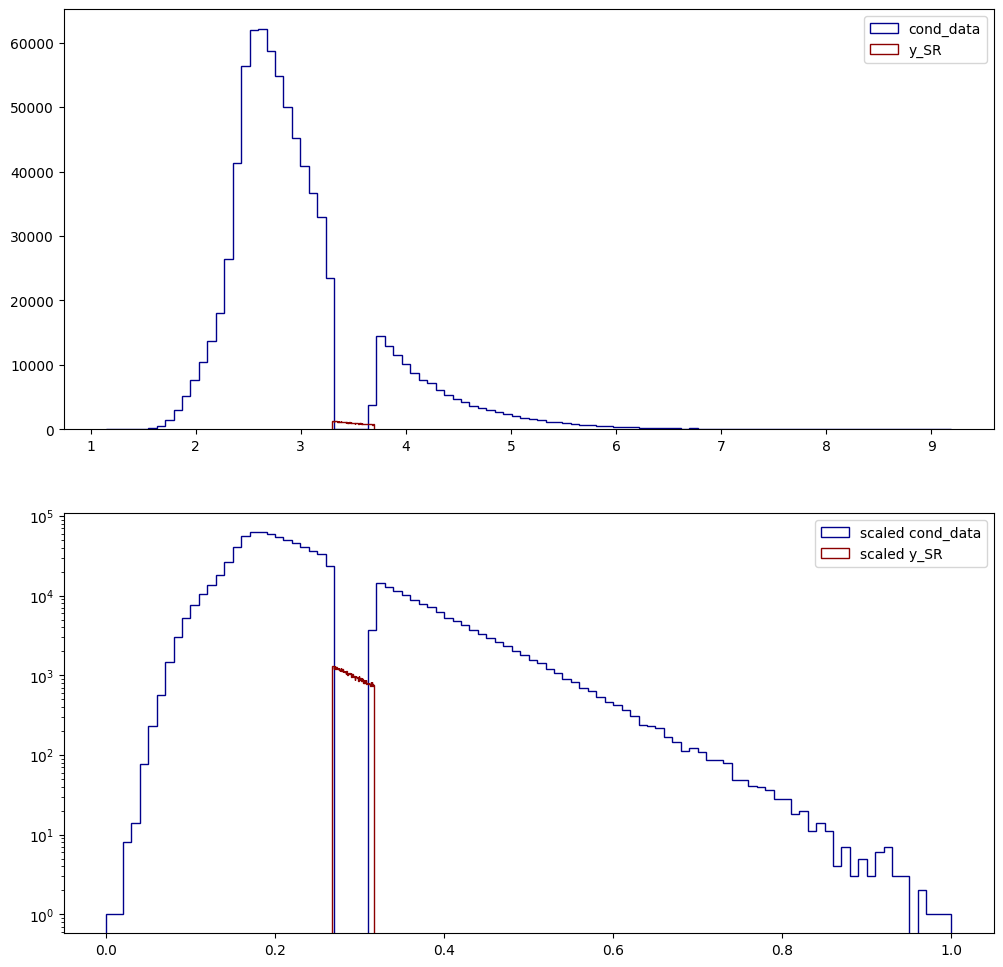

In [10]:
# combine cond_data and y_SR then apply min max normalization 
comb_cond_data = np.concatenate((cond_data, y_SR), axis=0)
comb_cond_data, comb_cond_data_max, comb_cond_data_min  = minmax_norm_cond_data(comb_cond_data)

# now seprate them again
cond_data = comb_cond_data[:len(cond_data)]
y_SR = comb_cond_data[len(cond_data):]

# plot cond_data and y_SR on same canvas before and after normalization
plt.figure(figsize=(12,12))
plt.subplot(2, 1, 1)
plt.hist(og_cond_data, bins=100, color = "darkblue",  histtype = "step", label = "cond_data")
plt.hist(og_y_SR, bins=100, color = "darkred",  histtype = "step", label = "y_SR")
plt.legend()
# plt.yscale('log')

plt.subplot(2, 1, 2)
plt.hist(cond_data, bins=100, color = "darkblue",  histtype = "step", label = "scaled cond_data")
plt.hist(y_SR, bins=100, color = "darkred",  histtype = "step", label = "scaled y_SR")
plt.legend()
plt.yscale('log')

plt.show()

## Setting up for training

### Defining the train and test sets

In [11]:
print("Data Shape: ", np.shape(data))
print("Data cond Shape: ", np.shape(cond_data))

# trainsize = trainsize = outerdata_train.shape[0]
# x_train = data[:trainsize]
# x_test = data[trainsize:]
# y_train = cond_data[:trainsize]
# y_test = cond_data[trainsize:]

x_train, x_test, y_train, y_test = train_test_split(data, cond_data, test_size=0.06, random_state=420)
trainsize = x_train.shape[0]

print("x_train Shape: ", np.shape(x_train))
print("x_test Shape: ", np.shape(x_test))
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print("Data cond test Shape: ", np.shape(y_test))
print("Data cond train Shape: ", np.shape(y_train))
y_train = np.reshape(y_train, [-1, 1])
y_test = np.reshape(y_test, [-1, 1])
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
print("Data cond test Shape: ", np.shape(y_test))
print("Data cond train Shape: ", np.shape(y_train))

Data Shape:  (778648, 6)
Data cond Shape:  (778648,)
x_train Shape:  (731929, 6)
x_test Shape:  (46719, 6)
Data cond test Shape:  (46719,)
Data cond train Shape:  (731929,)
Data cond test Shape:  (46719, 1)
Data cond train Shape:  (731929, 1)


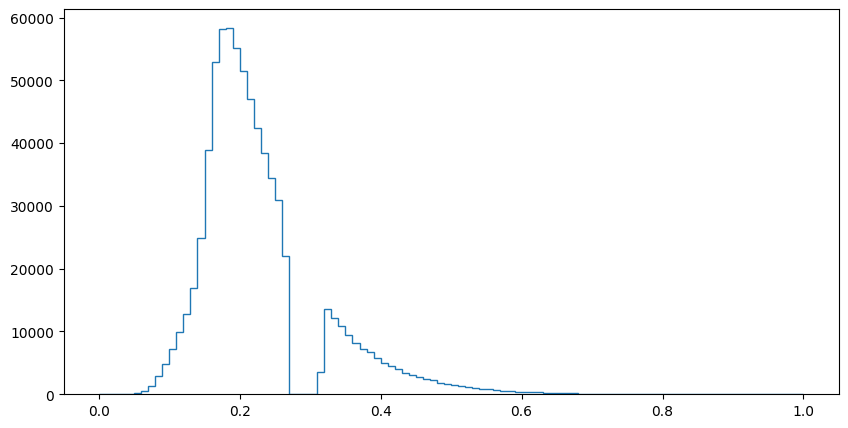

In [12]:
plt.figure(figsize=(10,5))
# plt.hist(og_cond_data[og_cond_data<3.3], bins=100, histtype='step', label="cond_data")
plt.hist(y_train, bins=100, histtype='step')
# plt.title('cond_data < 3.3 TeV')

plt.show()


### Network parameters

In [13]:
# network parameters
batch_size = 512
latent_dim = 6
epochs_1 = 101
# epochs_2 = 120

In [14]:
#note: min-max norm is present in all version
# folder_name = "cVAEz6_05-02-2023/"
folder_name = 'cVAEz4_05-9-2023'
comd = "mkdir -p "+"/global/u2/a/agarabag/pscratch/GAEA/outputs/models/"+folder_name
os.system(comd)


0

### Function for Gaussian Sampling in the VAE

In [15]:

def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

### Define the Encoder 

In [16]:
def create_encoder(X,y):
    # inputs = Concatenate()([X, y])  
    
    x1 = Dense(32, activation='relu')(X)
    x2 = Dense(64, activation='relu')(x1)
    x3 = Dense(64, activation='relu')(x2)
    x4 = Dense(32, activation='relu')(x3)
    
    z_mean = Dense(latent_dim, name='z_mean')(x4)
    z_log_var = Dense(latent_dim, name='z_log_var')(x4)
    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    return Model([X, y], [z_mean, z_log_var,  z], name='encoder')

### Define the Decoder

In [17]:
def create_decoder(z,y):
    # latent_inputs = Concatenate()([z, y])
    
    x1 = Dense(32, activation='relu')(z)
    x2 = Dense(64, activation='relu')(x1)
    x3 = Dense(64, activation='relu')(x2)
    x4 = Dense(32, activation='relu')(x3)
    
    outputs = Dense(input_dim, activation='linear')(x4)

    return Model([z, y], outputs, name='decoder')

In [18]:
# instantiate encoder model
encoder = create_encoder(Input(shape=(input_dim,)), Input(shape=(1,)))
encoder.summary()




Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           224         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           2112        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           4160        dense_1[0][0]                    
____________________________________________________________________________________________

In [19]:
# instantiate decoder model
decoder = create_decoder(Input(shape=(latent_dim,)), Input(shape=(1,)))
decoder.summary()


Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 32)           224         input_3[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 64)           2112        dense_4[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 64)           4160        dense_5[0][0]                    
____________________________________________________________________________________________

### Define the full VAE model

In [20]:
X_input = Input(shape=(input_dim,))
y_input = Input(shape=(1,))

z_mean, z_log_var, z = encoder([X_input,y_input])
outputs = decoder([z,y_input])
cvae = Model([X_input, y_input], outputs)

### Define the loss functions

In [21]:
def mse_loss_fn(x, x_decoded_mean):
#     mse_loss = mse(x, x_decoded_mean) # objectives.mean_squared_error(x, x_decoded_mean)

    mse_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.mse(x, x_decoded_mean)
            )
        )
    return mse_loss
    
def kl_loss_fn(x,  x_decoded_mean):
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return kl_loss
            
def vae_loss(x, x_decoded_mean):
#         mse_loss = mse(x, x_decoded_mean) # objectives.mean_squared_error(x, x_decoded_mean)
    mse_loss = mse_loss_fn(x, x_decoded_mean)
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    beta = 0.001 
    loss = K.mean((1-beta)*mse_loss + beta*kl_loss)
    return loss

### Custom Saver function

In [22]:
class CustomSaver(Callback):
    def on_epoch_end(self, epoch, logs={}):
        # if ((k == (iterations-1)):
        if (epoch+1)%10 == 0:
            decoder.save("/global/u2/a/agarabag/pscratch/GAEA/outputs/models/{}/model_cbvae_6var_m{}.h5".format(folder_name,epoch))
            encoder.save("/global/u2/a/agarabag/pscratch/GAEA/outputs/models/{}/encoder_cbvae_6var_m{}.h5".format(folder_name,epoch))
decoderSaver = CustomSaver()

### Other network parameters and model compilation

In [23]:
learnrate = 0.0025 #for z6
iterations = 3
lr_limit = learnrate/(2**iterations)
history = History()
k=0

In [24]:
checkpointer = ModelCheckpoint(filepath='/global/u2/a/agarabag/pscratch/GAEA/outputs/models/%s/cbvae_LHCO2020_20d_e-6.hdf5'%(folder_name), verbose=1, save_best_only=True)
opt = Adam(learning_rate=learnrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
cvae.compile(optimizer=opt, loss=vae_loss)
cvae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 6), (None, 6 8972        input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
decoder (Functional)            (None, 6)            8774        encoder[0][2]                

## Training loop

In [ ]:
list_loss = []
list_val_loss = [] 

while learnrate > lr_limit:
    # if k < 4:
    #     opt = Adam(learning_rate=learnrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    #     epochs = epochs_1
    # else:
    #     opt = SGD(learning_rate=learnrate, decay=1e-6, momentum=0.9, nesterov=True)
    #     epochs = epochs_2
    
    #Using only one opt
    opt = Adam(learning_rate=learnrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    epochs = epochs_1
    
    cvae.compile(loss=vae_loss, optimizer=opt, metrics=[mse_loss_fn, kl_loss_fn])
    cvae.fit([x_train, y_train], x_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=([x_test, y_test], x_test),
            callbacks = [checkpointer, history, decoderSaver])
    cvae.load_weights('/global/u2/a/agarabag/pscratch/GAEA/outputs/models/%s/cbvae_LHCO2020_20d_e-6.hdf5'%(folder_name))

    learnrate /= 2
    k=k+1

list_loss = np.append(list_loss, history.history['loss'])
list_val_loss = np.append(list_val_loss, history.history['val_loss'])

    
cvae.save_weights('/global/u2/a/agarabag/pscratch/GAEA/outputs/models/%s/cbvae_LHCO2020_20d_e-6.h5'%(folder_name))



Train on 731929 samples, validate on 46719 samples


2023-05-10 18:29:28.596049: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-10 18:29:29.106744: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38229 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


Epoch 1/101
 36352/731929 [>.............................] - ETA: 15s - loss: 17.6138 - mse_loss_fn: 17.6205 - kl_loss_fn: 10.9468 

2023-05-10 18:29:29.914226: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


729600/731929 [============================>.] - ETA: 0s - loss: 1.5434 - mse_loss_fn: 1.5038 - kl_loss_fn: 41.0910
Epoch 00001: val_loss improved from inf to 0.05607, saving model to /global/u2/a/agarabag/pscratch/GAEA/outputs/models/cVAEz4_05-9-2023_just_vae/cbvae_LHCO2020_20d_e-6.hdf5


/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.6.0/lib/python3.9/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


731929/731929 [==============================] - 4s 5us/sample - loss: 1.5386 - mse_loss_fn: 1.4986 - kl_loss_fn: 41.0844 - val_loss: 0.0561 - val_mse_loss_fn: 0.0172 - val_kl_loss_fn: 38.7559
Epoch 2/101
719360/731929 [============================>.] - ETA: 0s - loss: 0.0633 - mse_loss_fn: 0.0283 - kl_loss_fn: 35.0589
Epoch 00002: val_loss improved from 0.05607 to 0.04526, saving model to /global/u2/a/agarabag/pscratch/GAEA/outputs/models/cVAEz4_05-9-2023_just_vae/cbvae_LHCO2020_20d_e-6.hdf5
731929/731929 [==============================] - 3s 4us/sample - loss: 0.0632 - mse_loss_fn: 0.0282 - kl_loss_fn: 35.0171 - val_loss: 0.0453 - val_mse_loss_fn: 0.0125 - val_kl_loss_fn: 32.6580
Epoch 3/101
721408/731929 [============================>.] - ETA: 0s - loss: 0.0559 - mse_loss_fn: 0.0245 - kl_loss_fn: 31.4029
Epoch 00003: val_loss improved from 0.04526 to 0.04040, saving model to /global/u2/a/agarabag/pscratch/GAEA/outputs/models/cVAEz4_05-9-2023_just_vae/cbvae_LHCO2020_20d_e-6.hdf5
7319

In [15]:
#this endocer and decoder is same as the ones used in above cell to save mean and std
folder = "/global/u2/a/agarabag/pscratch/GAEA/outputs/models/%s"%folder_name
encoder = keras.models.load_model(folder+'/encoder_cbvae_6var_m99.h5')
decoder = keras.models.load_model(folder+'/model_cbvae_6var_m99.h5')

# # latent mean
# mean = encoder.predict([x_train, y_train])[0]
# # latent log variance --> variance --> std
# latent_logvar = encoder.predict([x_train, y_train])[1]
# latent_var = np.exp(latent_logvar)
# std = np.sqrt(latent_var)

# Save the latent mean and atd values
# np.savetxt('/global/u2/a/agarabag/pscratch/GAEA/outputs/models/%s/cbvae_LHCO2020_latent_mean_20d_e-6.csv'%folder_name, mean)
# np.savetxt('/global/u2/a/agarabag/pscratch/GAEA/outputs/models/%s/cbvae_LHCO2020_latent_std_20d_e-6.csv'%folder_name, std)

2023-05-12 10:31:44.150606: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-05-12 10:31:45.239912: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31235 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [26]:
# Predict the mean and std from the training dataset
# latent mean
latent_mean = encoder.predict([x_train, y_train])[0]
# latent log variance --> variance --> std
latent_logvar = encoder.predict([x_train, y_train])[1]
latent_var = np.exp(latent_logvar)
latent_std = np.sqrt(latent_var)

# Save the latent mean and atd values
np.savetxt('/global/u2/a/agarabag/pscratch/GAEA/outputs/models/%s/cbvae_LHCO2020_latent_mean_20d_e-6.csv'%folder_name, latent_mean)
np.savetxt('/global/u2/a/agarabag/pscratch/GAEA/outputs/models/%s/cbvae_LHCO2020_latent_std_20d_e-6.csv'%folder_name, latent_std)

# Save the loss values
np.save("/global/u2/a/agarabag/pscratch/GAEA/outputs/models/%s/cbvae_LHCO2020_val_loss.npy"%folder_name, list_val_loss)
np.save("/global/u2/a/agarabag/pscratch/GAEA/outputs/models/%s/cbvae_LHCO2020_train_loss.npy"%folder_name, list_loss)

(303,)
0.025919616950023757


/tmp/ipykernel_220717/2819004165.py:18: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 5)


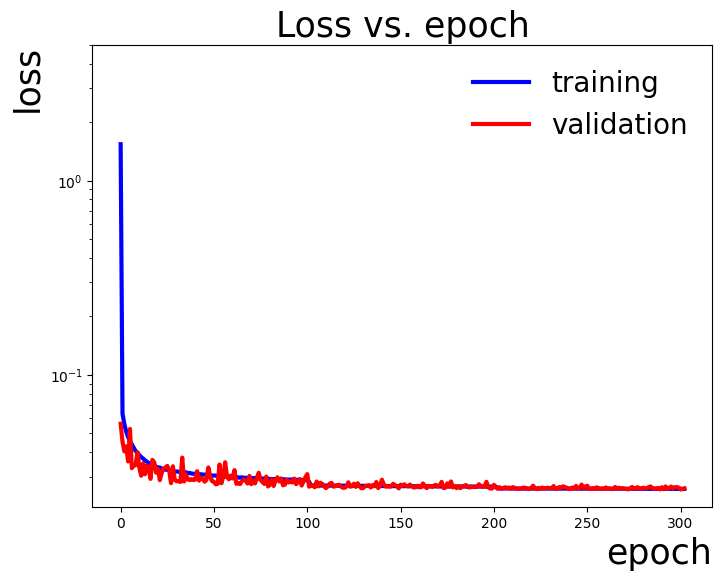

In [27]:
# plot loss function
list_val_loss = np.load("/global/u2/a/agarabag/pscratch/GAEA/outputs/models/%s/cbvae_LHCO2020_val_loss.npy"%folder_name)
list_loss = np.load("/global/u2/a/agarabag/pscratch/GAEA/outputs/models/%s/cbvae_LHCO2020_train_loss.npy"%folder_name)
print(list_loss.shape)
print(np.min(list_loss))
fig, ax = plt.subplots(1,1, figsize=(8,6))

plt.plot(np.arange(0,epochs_1*iterations), list_loss, label='training',c='blue',linewidth = 3)
plt.plot(np.arange(0,epochs_1*iterations), list_val_loss, label='validation',c='red',linewidth = 3)

plt.title("Loss vs. epoch", fontsize=25)

ax.set_ylabel('loss', fontsize=25,horizontalalignment='right',y=1)
ax.set_xlabel('epoch', fontsize=25,horizontalalignment='right',x=1)
#log scale y axis
ax.set_yscale('log')
#set x limit
ax.set_ylim(0, 5)
plt.legend(loc='best', prop={'size':20}, edgecolor = "w",fancybox=False, framealpha=0)
plt.show()

In [16]:
# Read the mean values
filename = '/global/u2/a/agarabag/pscratch/GAEA/outputs/models/%s/cbvae_LHCO2020_latent_mean_20d_e-6.csv'%folder_name
means_df = pd.read_csv(filename, sep=' ', header=None)
mean = means_df.values

print(mean.shape)

# Read the std values
filename = '/global/u2/a/agarabag/pscratch/GAEA/outputs/models/%s/cbvae_LHCO2020_latent_std_20d_e-6.csv'%folder_name
stds_df = pd.read_csv(filename, sep=' ', header=None)
std = stds_df.values

(731929, 6)


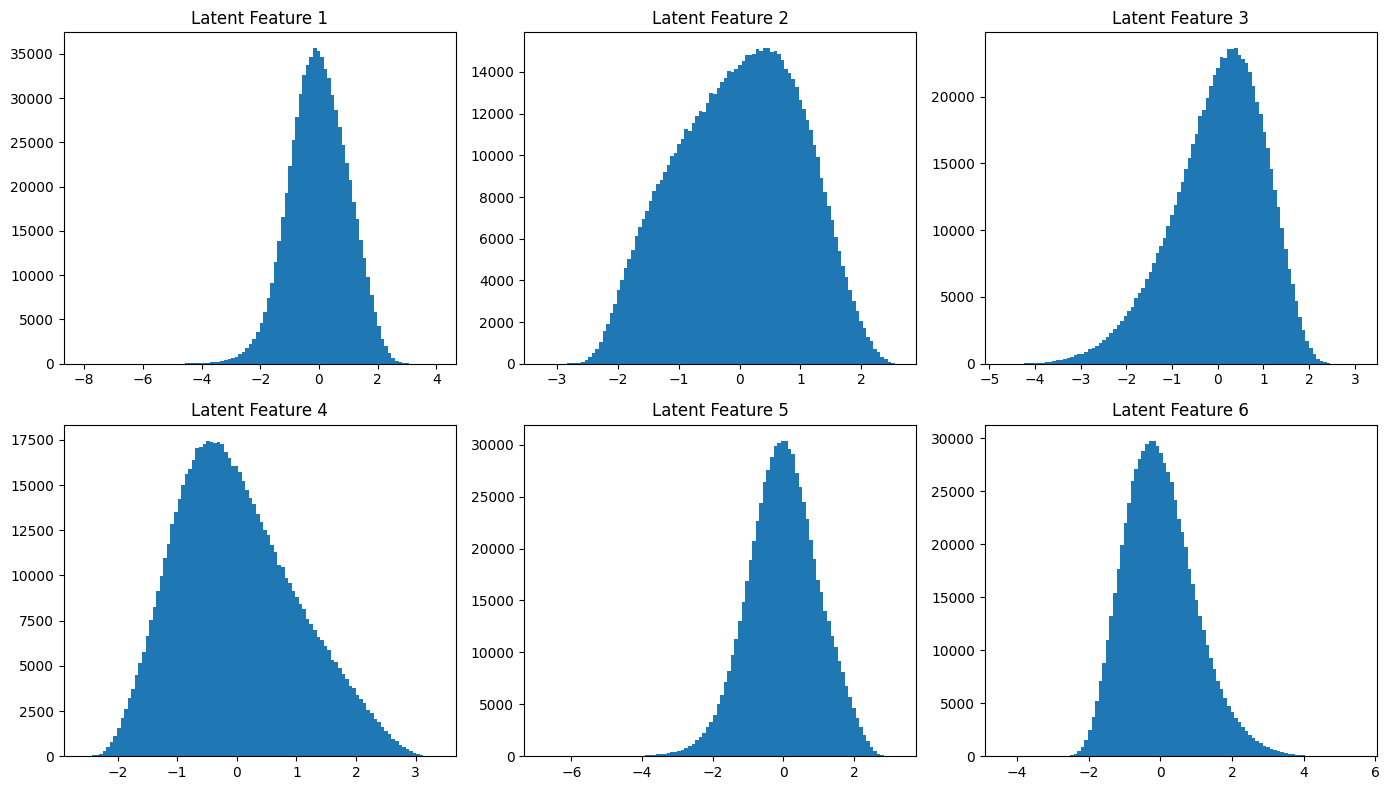

In [17]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8))  # Create a 2x3 grid of subplots

for i in range(2):
    for j in range(3):
        axs[i, j].hist(mean[:, i * 3 + j], bins=100)  # Plot the histogram for the corresponding feature
        axs[i, j].set_title(f'Latent Feature {i * 3 + j + 1}')  # Set the subplot title

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()


In [30]:
z_samples = np.empty([cond_data.shape[0],latent_dim])
l=0
for i in range(0,cond_data.shape[0]):
    for j in range(0,latent_dim):
        z_samples[l,j] = np.random.normal(mean[i%trainsize,j], 0.05+std[i%trainsize,j])
    l=l+1

# use normal gaussian as z 
# z_samples = np.random.normal(size=(cond_data.shape[0], latent_dim))

gen_SB = decoder.predict([z_samples, np.reshape(cond_data, [-1, 1])])

#reverse normalization
# gen_SB = expit_norm(new_events)
# gen_SB = rev_minmax_data(new_events, data_min, data_max)

os.system("mkdir -p /global/u2/a/agarabag/pscratch/GAEA/outputs/gen_dataset/%s/"%folder_name)
np.save('/global/u2/a/agarabag/pscratch/GAEA/outputs/gen_dataset/%s/LHCO2020_cB-VAE_events_SB.npy'%folder_name, gen_SB)

/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.6.0/lib/python3.9/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [13]:

# Obtain latent space using encoder
latent_data = np.concatenate([mean, std], axis=1)
print(mean.shape, std.shape, latent_data.shape)
# print(mean)
# print("######################")
# print(std)
# print("######################")
# print(latent_data)

#Fit Gaussian mixture model on latent space
gmm = GaussianMixture(n_components=100, covariance_type='full', random_state=42)
gmm.fit(latent_data)


(849779, 6) (849779, 6) (849779, 12)


GaussianMixture(n_components=100, random_state=42)

In [14]:
#save GMM
np.save('outputs/gen_dataset/%s/SB_gmm_weights'%folder_name, gmm.weights_, allow_pickle=False)
np.save('outputs/gen_dataset/%s/SB_gmm_means'%folder_name, gmm.means_, allow_pickle=False)
np.save('outputs/gen_dataset/%s/SB_gmm_cov'%folder_name, gmm.covariances_, allow_pickle=False)

In [17]:
# reload gmm
means = np.load('outputs/gen_dataset/%s/SB_gmm_means.npy'%folder_name)
covar = np.load('outputs/gen_dataset/%s/SB_gmm_cov.npy'%folder_name)
loaded_gmm = GaussianMixture(n_components = len(means), covariance_type='full')
loaded_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
loaded_gmm.weights_ = np.load('outputs/gen_dataset/%s/SB_gmm_weights.npy'%folder_name)
loaded_gmm.means_ = means
loaded_gmm.covariances_ = covar

new_z_samples = loaded_gmm.sample(cond_data.shape[0])

In [18]:
# Sample new latent vectors from the GMM
# new_z_samples = gmm.sample(cond_data.shape[0])

z_samples = np.array(new_z_samples[0])[:, :6]

# Decode the sampled latent vectors to generate new data points
gen_SB = decoder.predict([z_samples, np.reshape(cond_data, [-1, 1])])

gen_SB = rev_minmax_data(new_events, data_min, data_max)

# os.system("mkdir -p ./outputs/gen_dataset/%s/"%folder_name)
np.save('outputs/gen_dataset/%s/LHCO2020_cB-VAE_gmm_z_events_lower_new_SB.npy'%folder_name, gen_SB)

In [14]:
file_gen_SB = '/global/u2/a/agarabag/pscratch/GAEA/outputs/gen_dataset/%s/LHCO2020_cB-VAE_events_SB.npy'%folder_name
gen_SB = np.load(file_gen_SB)
# gen_SB = pd.read_csv(file_gen_SB, delimiter = ' ', header=None, index_col=False)
# gen_SB = gen_SB.to_numpy()
print("shape of gen_SR: ", gen_SB.shape)


shape of gen_SR:  (778648, 6)


In [31]:
plotting_ranges = [(0,0.8), (0,1), (0,1), (0,1), (0,1), (0,1)]

def fake_vs_real(gen_data,real_data,doLog,names):
    
    plt.figure(figsize=(20,15))
    colors = ["steelblue", "darkturquoise"]
    for p in range(0,nFeat):
        R = np.linspace(plotting_ranges[p][0],plotting_ranges[p][1],51)
        plt.subplot((nFeat+1)//2, 2, p+1)
        for rd in real_data: b_hist_y, b_hist_x, _ = plt.hist(rd[:,p], R, color="black", histtype='step', linewidth=2, label="MC Bkg", density=True)        
        for i,n in enumerate(gen_data): plt.hist(n[:,p], R, color=colors[i], histtype='stepfilled', alpha=0.5, linewidth=2, label="Generated Bkg %s"%names[i], density=True)
        # s_hist_y, s_hist_x, _ = plt.hist(sig_data[:,p], R, color="r", histtype='step', linewidth=3, label="Signal", density=True)
        plt.xlabel("%s"%feature_labels[p])
        if doLog == True: plt.yscale('log')
        plt.ylabel("Number of Events / bin")
        plt.legend(fontsize="large")
        # ymax_b = np.max(b_hist_y)
        # ymax_s = np.max(s_hist_y)
        # plt.ylim(0,ymax_b*1.5)
#     plt.savefig("fake_gen_compare_cbvae_6var_dynamicbeta.png")

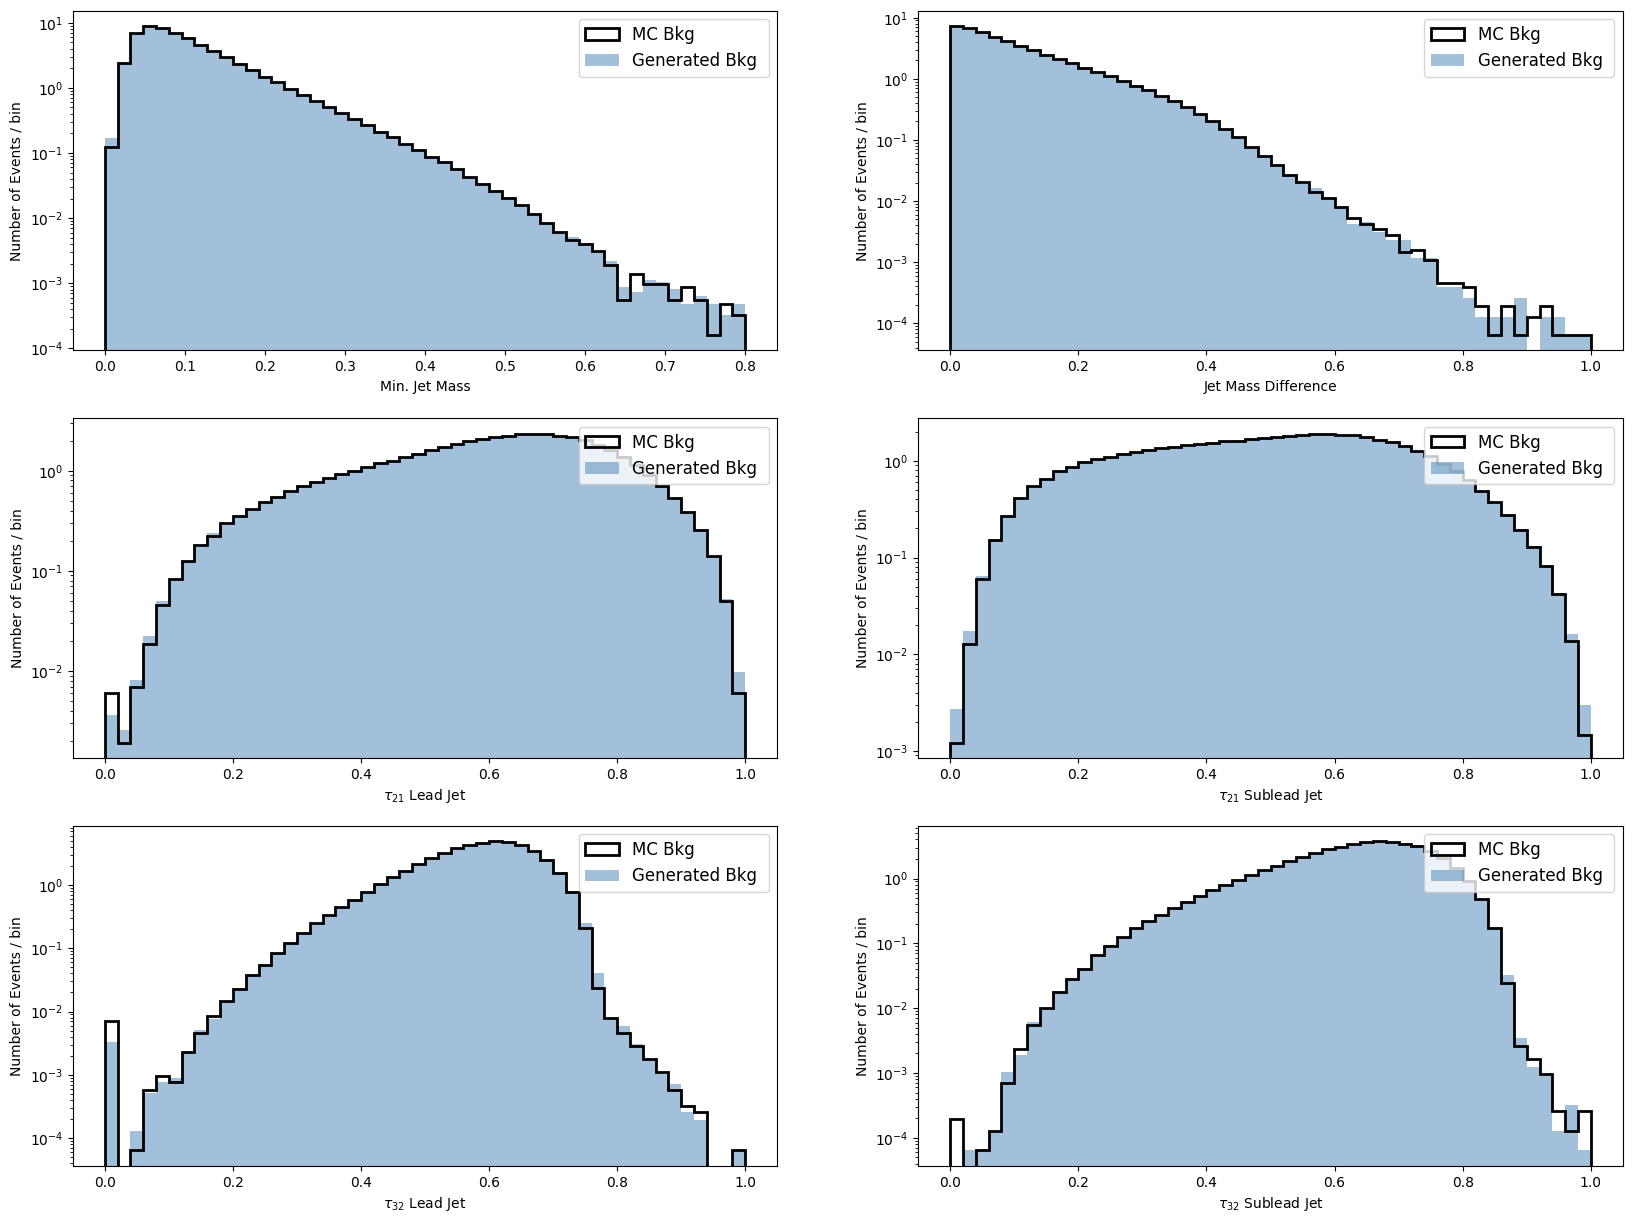

In [32]:
fake_vs_real([gen_SB],[data],1,[""])

In [33]:
from sklearn.neighbors import KernelDensity

# Generate SR data 
KDE_bandwidth = 0.01
mjj_logit = quick_logit(y_SR)
y_SR_new = logit_transform_inverse(KernelDensity(
                  bandwidth=KDE_bandwidth, kernel='gaussian').fit(
                  mjj_logit.reshape(-1, 1)).sample(z_samples.shape[0]),
                                                   max(y_SR).item(),
                                                   min(y_SR).item())


gen_SR = decoder.predict([z_samples, np.reshape(y_SR_new, [-1, 1])])

# gen_SR = rev_minmax_data(gen_SR, x_SR_min, x_SR_max)

np.save('/global/u2/a/agarabag/pscratch/GAEA/outputs/gen_dataset/%s/LHCO2020_cB-VAE_events_SR.npy'%folder_name, gen_SR)

In [44]:
rand_y = np.random.normal(size=(cond_data.shape[0],1))

In [45]:
rand_y.shape

(778648, 1)

In [46]:
rand_gen = decoder.predict([z_samples, rand_y])

In [20]:
sub_cond_data = cond_data[(cond_data >= 0.4) & (cond_data <= 0.45)]


In [21]:
sub_data = data[(cond_data >= 0.4) & (cond_data <= 0.45)]


In [22]:
sub_z_samples = np.empty([sub_cond_data.shape[0],latent_dim])
l=0
for i in range(0,sub_cond_data.shape[0]):
    for j in range(0,latent_dim):
        sub_z_samples[l,j] = np.random.normal(mean[i%trainsize,j], 0.05+std[i%trainsize,j])
    l=l+1
sub_gen = decoder.predict([sub_z_samples, np.reshape(sub_cond_data, [-1, 1])])

/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.6.0/lib/python3.9/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2023-05-12 10:39:57.940212: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [23]:
lower_sub_cond_data = cond_data[(cond_data >= 0.1) & (cond_data <= 0.15)]
lower_sub_data = data[(cond_data >= 0.1) & (cond_data <= 0.15)]


In [24]:
lower_sub_z_samples = np.empty([lower_sub_cond_data.shape[0],latent_dim])
l=0
for i in range(0,lower_sub_cond_data.shape[0]):
    for j in range(0,latent_dim):
        lower_sub_z_samples[l,j] = np.random.normal(mean[i%trainsize,j], 0.05+std[i%trainsize,j])
    l=l+1
lower_sub_gen = decoder.predict([lower_sub_z_samples, np.reshape(lower_sub_cond_data, [-1, 1])])

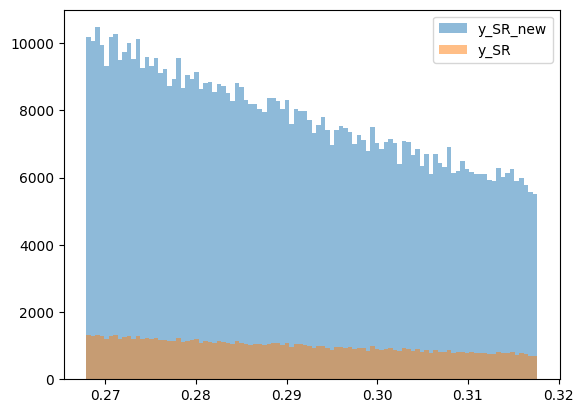

In [25]:
# plot cond_data and y_SR together
plt.hist(y_SR_new , bins=100, alpha=0.5, label="y_SR_new")
plt.hist(y_SR, bins=100, alpha=0.5, label="y_SR")
plt.legend(loc='upper right')

plt.show()

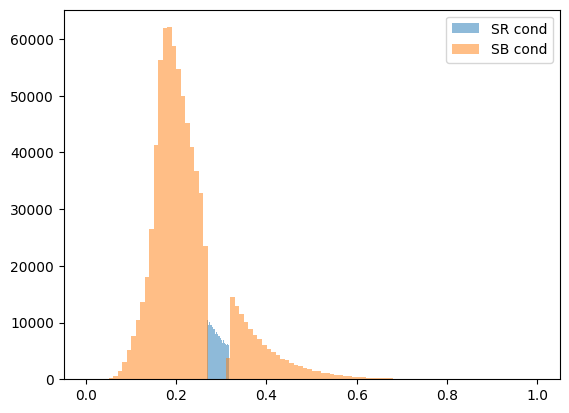

In [26]:
# plot cond_data and y_SR together
plt.hist(y_SR_new , bins=100, alpha=0.5, label="SR cond")
plt.hist(cond_data, bins=100, alpha=0.5, label="SB cond")
plt.legend(loc='upper right')

plt.show()

In [25]:
plotting_ranges = [(0,0.8), (0,1), (0,1), (0,1), (0,1), (0,1)]

def fake_vs_real2(gen_data, mc_sb_data, mc_sr_data, doLog, names):
    
    plt.figure(figsize=(20,15))
    colors = ["steelblue", "darkturquoise"]
    for p in range(0,nFeat):
        R = np.linspace(plotting_ranges[p][0],plotting_ranges[p][1],51)
        plt.subplot((nFeat+1)//2, 2, p+1)
        for rd in mc_sb_data: b_hist_y, b_hist_x, _ = plt.hist(rd[:,p], R, color="black", histtype='step', linewidth=2, label="SB_MC", density=True)        
        for rd in mc_sr_data: b_hist_y, b_hist_x, _ = plt.hist(rd[:,p], R, color="red", histtype='step', linewidth=2, label="SR_MC", density=True)
        for i,n in enumerate(gen_data): plt.hist(n[:,p], R, color=colors[i], histtype='stepfilled', alpha=0.5, linewidth=2, label="Gen Bkg %s"%names[i], density=True)
        plt.xlabel("%s"%feature_labels[p])
        if doLog == True: plt.yscale('log')
        plt.ylabel("Number of Events / bin")
        plt.legend(fontsize="large")


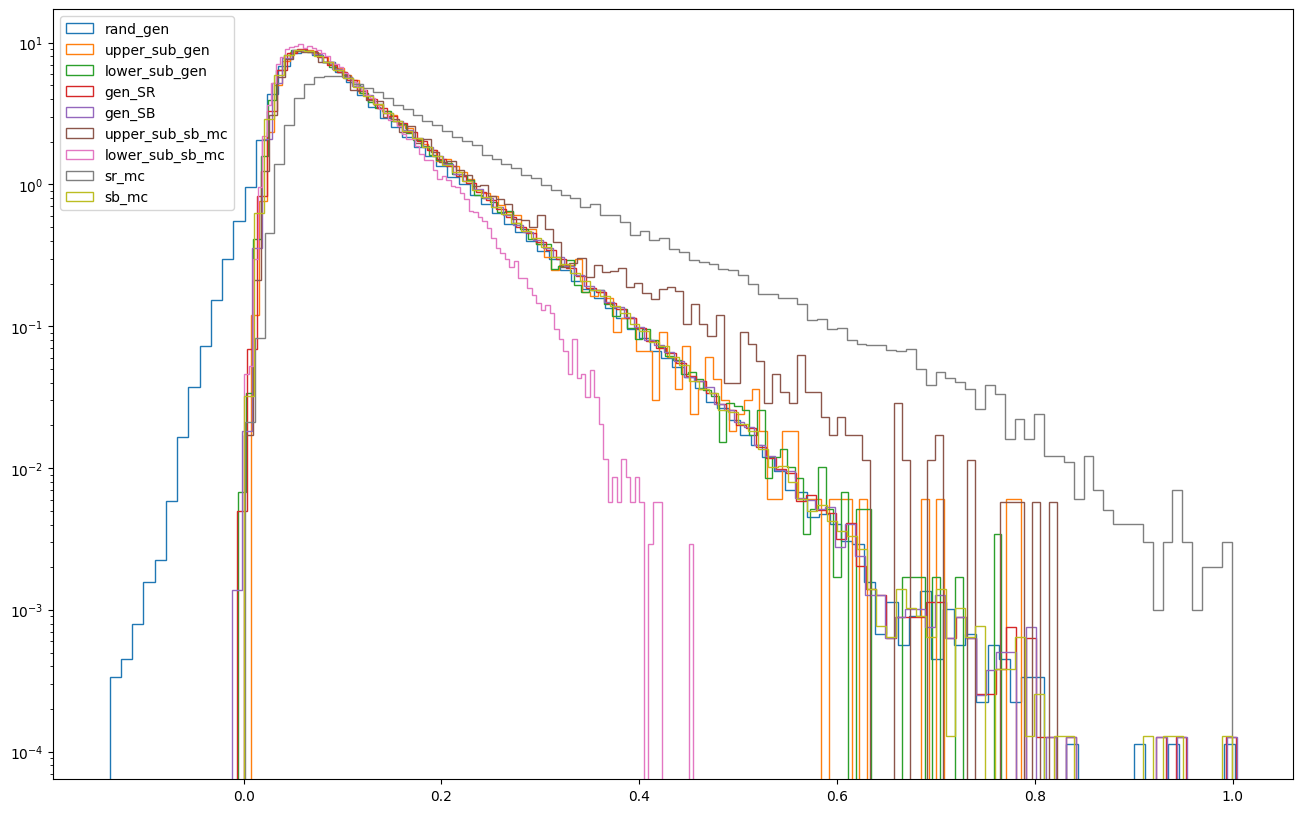

In [54]:

plt.figure(figsize=(16,10))
f_num = 0
plt.hist(rand_gen[:,f_num], bins=100, histtype='step', label="rand_gen", density=True)
plt.hist(sub_gen[:,f_num], bins=100, histtype='step', label="upper_sub_gen", density=True)
plt.hist(lower_sub_gen[:,f_num], bins=100, histtype='step', label="lower_sub_gen", density=True)
plt.hist(gen_SR[:,f_num], bins=100, histtype='step', label="gen_SR", density=True)
plt.hist(gen_SB[:,f_num], bins=100, histtype='step', label="gen_SB", density=True)


plt.hist(sub_data[:, f_num], bins=100, histtype='step', label="upper_sub_sb_mc", density=True)
plt.hist(lower_sub_data[:, f_num], bins=100, histtype='step', label="lower_sub_sb_mc", density=True)
plt.hist(x_SR[:, f_num], bins=100, histtype='step', label="sr_mc", density=True)
plt.hist(data[:, f_num], bins=100, histtype='step', label="sb_mc", density=True)

plt.yscale('log')
plt.legend()

plt.show()


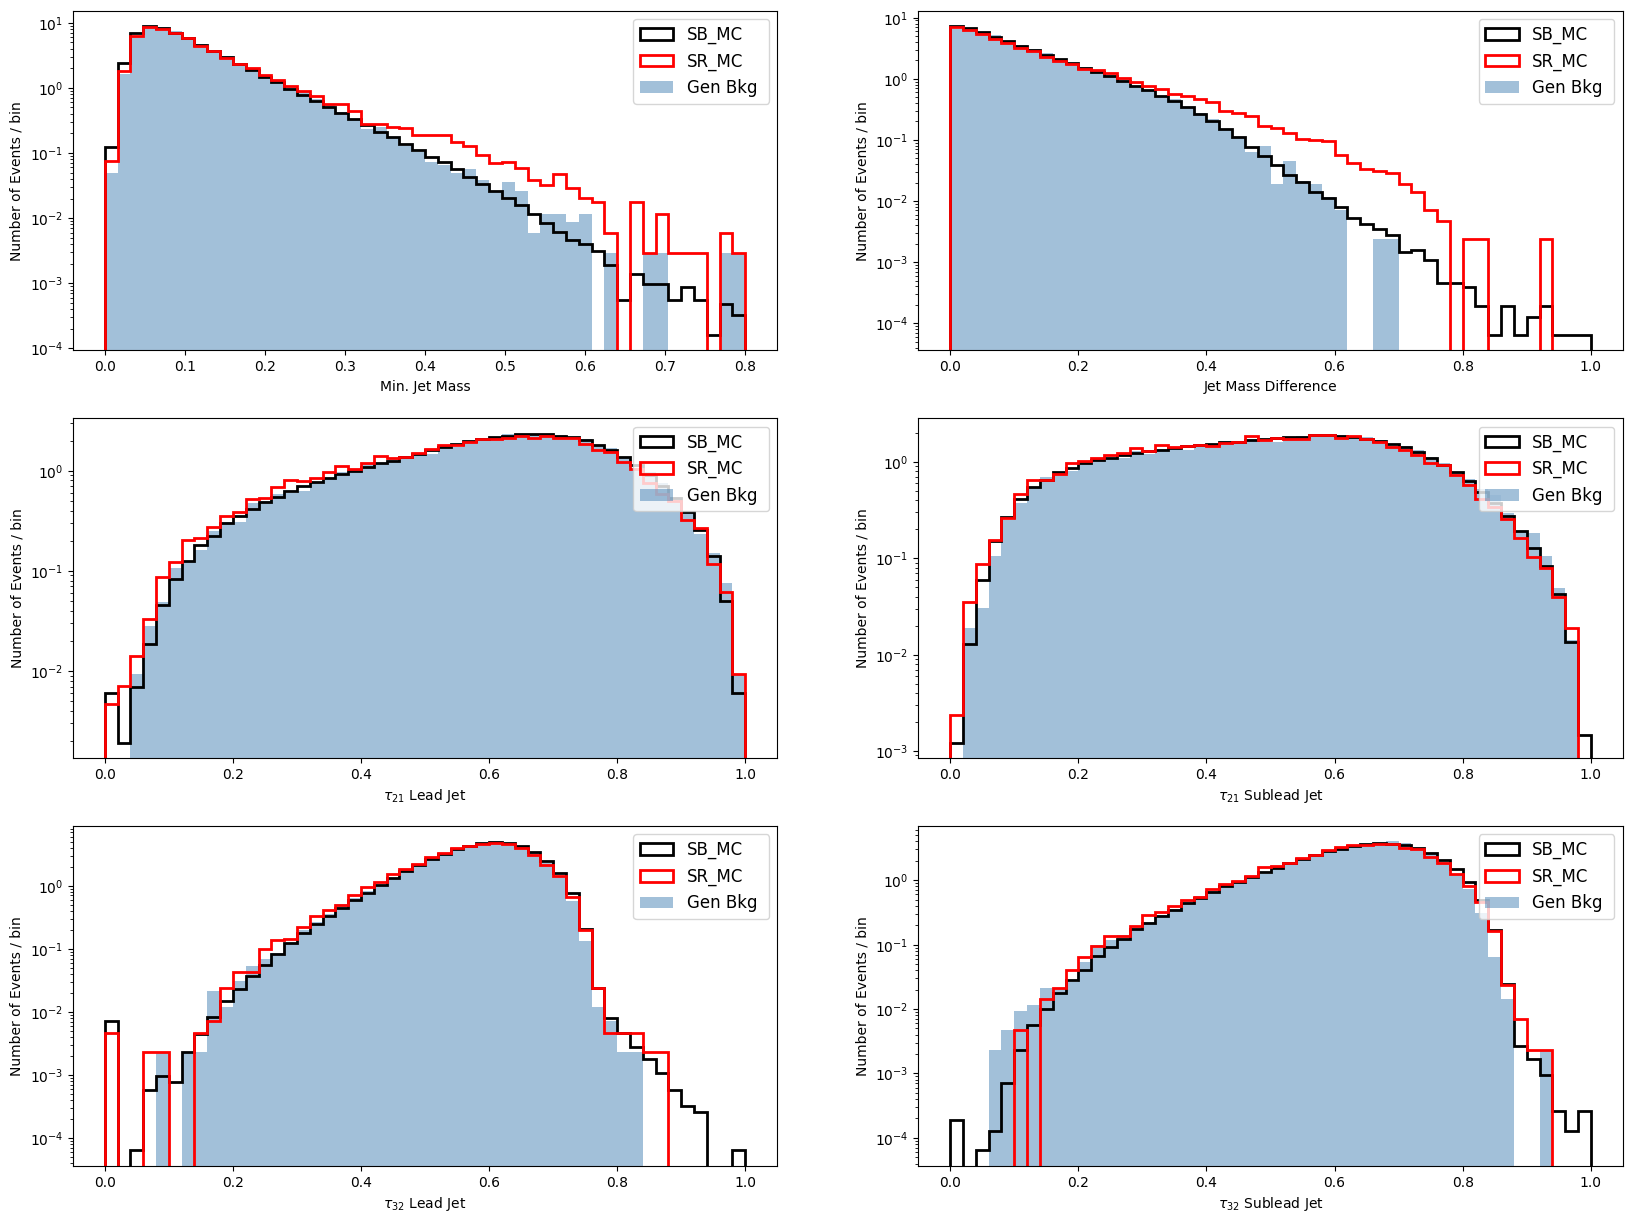

In [30]:
# file_gen_SR = 'outputs/gen_dataset/%s/LHCO2020_cB-VAE_gmm_z_events_SR.npy'%folder_name
# gen_SR = np.load(file_gen_SR)
# fake_vs_real2([gen_SR],[un_norm_data],[rev_minmax_data(x_SR, x_SR_min, x_SR_max)],1,[""])
# fake_vs_real2([rev_minmax_data(gen_SR, x_SR_min, x_SR_max)],[og_data],[og_x_SR],1,[""])
fake_vs_real2([sub_gen],[data],[sub_data],1,[""])


# fake_vs_real2([gen_SR],[un_norm_data[un_norm_data <= 3.3]],[rev_minmax_cond_data(x_SR, x_SR_min, x_SR_max)],1,[""])
# fake_vs_real2([gen_SR],[un_norm_data],[rev_minmax_cond_data(x_SR, x_SR_min, x_SR_max)],1,[""])

In [36]:
# variables_names =  train_features
# vnames = train_features

plotting_ranges = [(0,0.8), (0,1), (0,1), (0,1), (0,1), (0,1)]

def fake_vs_real3(gen_data, mc_sb_data, og_mc_sb_data, mc_sr_data, doLog, names):
    
    plt.figure(figsize=(20,15))
    colors = ["steelblue", "darkturquoise"]
    for p in range(0,nFeat):
        R = np.linspace(plotting_ranges[p][0],plotting_ranges[p][1],51)
        plt.subplot((nFeat+1)//2, 2, p+1)
        for rd in mc_sb_data: b_hist_y, b_hist_x, _ = plt.hist(rd[:,p], R, color="orange", histtype='step', linewidth=2, label="Val_SB_MC", density=True)        
        for rd in og_mc_sb_data: b_hist_y, b_hist_x, _ = plt.hist(rd[:,p], R, color="black", histtype='step', linewidth=2, label="Train_SB_MC", density=True)
        # for rd in mc_sr_data: b_hist_y, b_hist_x, _ = plt.hist(rd[:,p], R, color="red", histtype='step', linewidth=2, label="SR_MC", density=True)
        for i,n in enumerate(gen_data): plt.hist(n[:,p], R, color=colors[i], histtype='stepfilled', alpha=0.5, linewidth=2, label="Gen Bkg %s"%names[i], density=True)
        plt.xlabel("%s"%feature_labels[p])
        if doLog == True: plt.yscale('log')
        plt.ylabel("Number of Events / bin")
        plt.legend(fontsize="large")



In [37]:
x_val = outerdata_val[:,1:nFeat+1]
y_val = outerdata_val[:,0]

x_val, x_val_max, x_val_min  = minmax_norm_data(x_val)
y_val, y_val_max, y_val_min  = minmax_norm_cond_data(y_val)


KDE_bandwidth = 0.01
y_val_logit = quick_logit(y_val)
y_val_new = logit_transform_inverse(KernelDensity(
                  bandwidth=KDE_bandwidth, kernel='gaussian').fit(
                  y_val_logit.reshape(-1, 1)).sample(z_samples.shape[0]),
                                                   max(y_val).item(),
                                                   min(y_val).item())

comb_val_data = np.concatenate((y_val_new, y_SR.reshape(-1, 1)), axis=0)
comb_val_data, comb_val_data_max, comb_val_data_min  = minmax_norm_cond_data(comb_val_data)
y_val_new = comb_cond_data[:len(y_val_new)]
y_SR_w_val = comb_cond_data[len(y_val_new):]

val_gen = decoder.predict([z_samples, np.reshape(y_val_new, [-1, 1])])

In [38]:
# val_z_samples = np.empty([y_val.shape[0],latent_dim])
# l=0
# for i in range(0,y_val.shape[0]):
#     for j in range(0,latent_dim):
#         val_z_samples[l,j] = np.random.normal(mean[i%trainsize,j], 0.05+std[i%trainsize,j])
#     l=l+1
# val_gen = decoder.predict([val_z_samples, np.reshape(y_val, [-1, 1])])

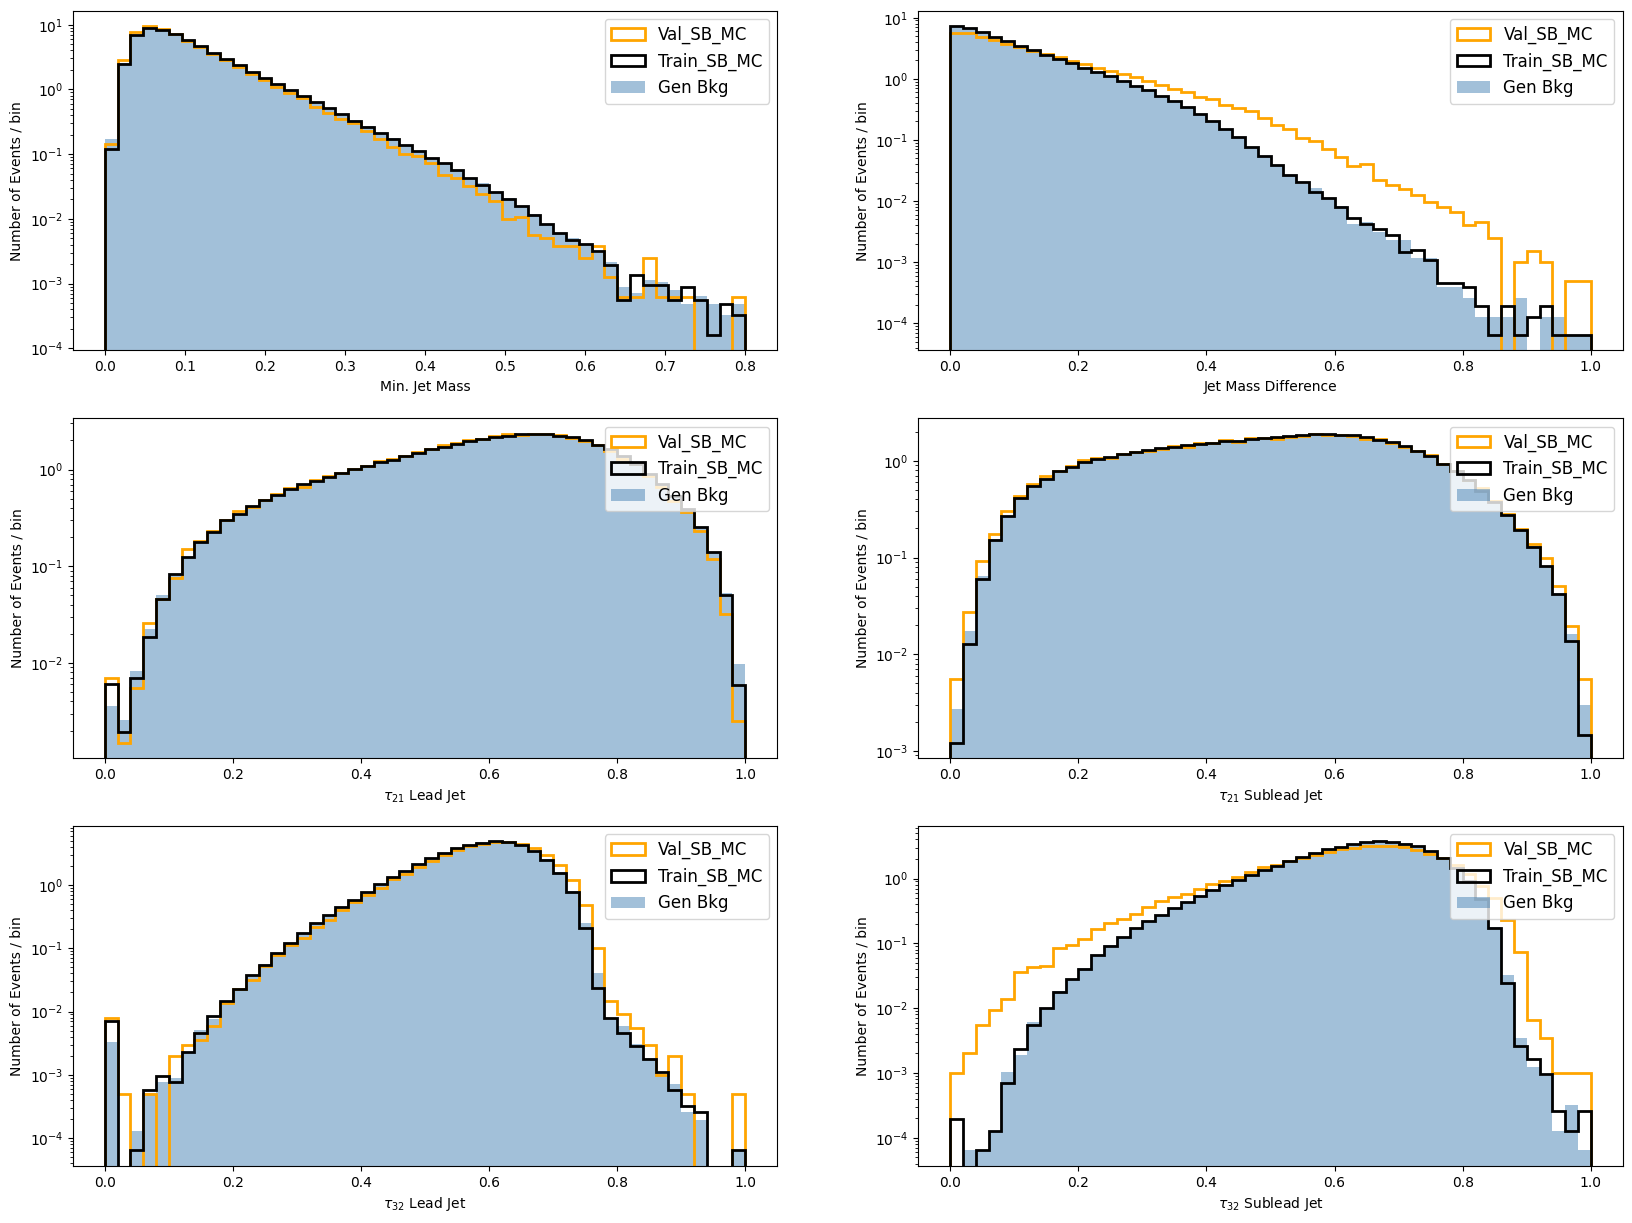

In [39]:
fake_vs_real3([val_gen],[x_val],[data],[x_val],1,[""])
